# BWW Challenge Level 1 - Getting started!                     

Welcome to the 2022 Better Working World Data Challenge!

This notebook will show you how to open and explore the data, identify problematic areas of the data, create a basic solution of the problem, and submit your results.

Prior to running this notebook, make sure you have:

1. Created a profile on the EY Data Science Platform
2. Registered for "BWW Challenge 2022 Level 1: Predict the probability of frog presence using climatic variables on the Platform



# Level 1: Binary Classification model – Predict the probability of frog presence using climatic variables

## To Do Task

Build a Binary Classification model to predict the presence of frog species on the basis of TerraClimate variables extracted from the Microsoft Planetary data catalog, which provides data for monthly climate and climatic water balance across global terrestrial surfaces from 1958 to the present. 

For demonstration purpose, a binary model has been prepared using two climate variables only using the FrogID dataset for the entire Australia region. Participants are expected to explore all the climatic variables from TerraClimate dataset to built best possible model using optimum data pre-processing activities. 

Participants **must include** frog presence dataset for the **time period Nov'2017 to Nov'2019** from Australia (frogID dataset) **excluding State Province = "South Australia" while building the model.**

**Model Accuracy Evaluation- An Out-of-sample validation dataset is provided to the contestants for predicting the frog presence status on the above excluded region (South Australia).**



## Datasets used

#### 1. Frog presence Data 
The dataset provides information about the presence of frogs across Australia over a period of 2 years from Nov'2017 to Nov'2019.

Data Source : [Global Biodiversity Information Facility](https://www.gbif.org/) portal.

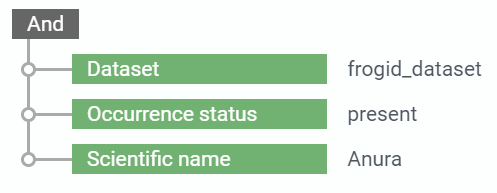

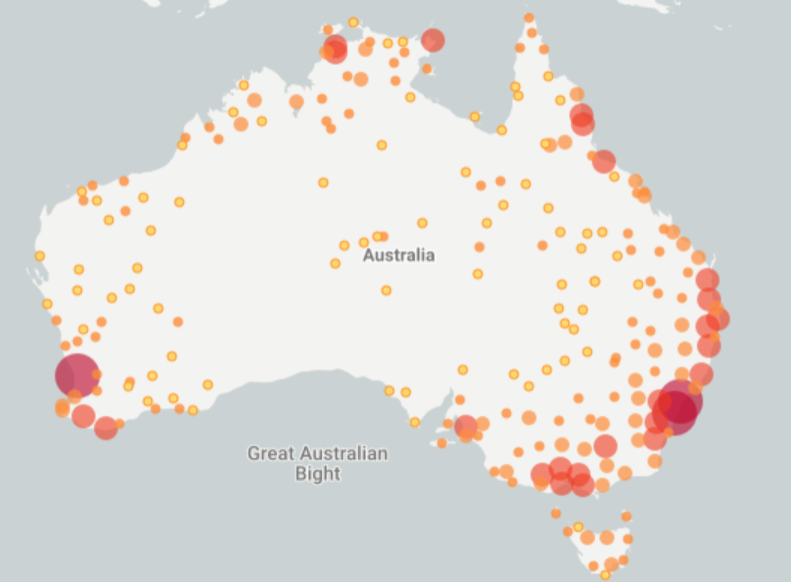

#### 2.  Climate Data 
TerraClimate data from Micorosoft Planetary catalog which provides monthly climate and climatic water balance for global terrestrial surfaces from 1958 to the present. The data provide important inputs for ecological and hydrological studies at global scales that require high spatial resolution and time-varying data.

Data Source : [Terraclimate dataset](https://planetarycomputer.microsoft.com/dataset/terraclimate) from the Microsoft Planetary Computer portal.

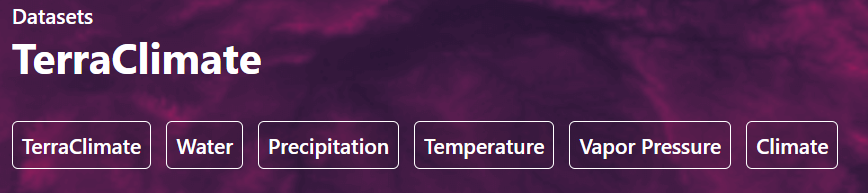
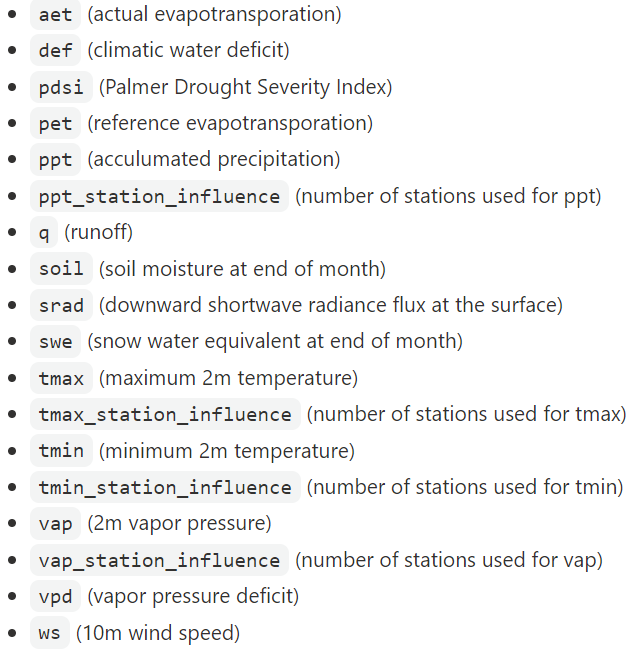

<br>
<br>


### Note: 
For demonstration purpose, a binary model has been prepared using two climate variables (vap and sard) only. Participants are expected to explore all the climatic variables from TerraClimate dataset to built best possible model using optimum data pre-processing activities.

## 1.Import required Libraries

In [1]:
import pandas as pd
import pystac
import fsspec
import xarray as xr
import datetime 
import numpy as np
import math
from tqdm import tqdm
from datetime import date
import pystac

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn import metrics

C:\software\anaconda\envs\python38\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


##  2.Load dataset

### 2.1.Loading frog presence data extracted from GBIF portal

In [7]:
df_frog = pd.read_csv("Frog_occurrence.csv",
                            usecols=['eventDate','year','month','decimalLatitude','decimalLongitude','occurrenceStatus'])

In [8]:
df_frog.head()

,occurrenceStatus,eventDate,year,month,decimalLatitude,decimalLongitude
0,PRESENT,2017-11-14T00:00:00,2017,11,-38.1,144.6
1,PRESENT,2017-11-25T00:00:00,2017,11,-26.7,153.1
2,PRESENT,2018-01-03T00:00:00,2018,1,-30.3,152.9
3,PRESENT,2018-01-26T00:00:00,2018,1,-12.6,131.1
4,PRESENT,2018-02-06T00:00:00,2018,2,-26.3,152.9


### 2.2.Loading non frog presence data 
For generating non frog presence geolocations (latitude & logitude), following steps have been implemented:
1) bbox finder(www.bboxfinder.com) used for identifying the latitude and logitude of area covering major regions of Australia

2) Random generation of lat and lon points within the defined range of lat and lon available from step-1 

3) Compare the non frog presence lat and lon points with the frog presence lat and lon points from FrogID dataset

4) Unmatched points are marked with the OccurenceStatus == 0 (Absent) post removing duplicated lat and lon points

In [9]:
df_nonfrog = pd.read_csv("Frog_non_presence.csv", nrows=5000)

In [10]:
df_nonfrog.head()

,lon,lat
0,141.9,-27.8
1,140.0,-23.1
2,147.9,-36.1
3,140.9,-34.9
4,138.6,-36.0


### 2.3.Loading TerraClimate data from Microsoft Planetary Data Catalog

In [2]:
url = "https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate"
collection = pystac.read_file(url)
asset = collection.assets["zarr-https"]
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [3]:
ds

,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,103.45 GiB,94.92 MiB
Shape,"(744, 4320, 8640)","(12, 1440, 1440)"
Count,1117 Tasks,1116 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## 3.Custom methods/functions for data preparation

### 3.1 Function to truncate decimal values

In [12]:
# input: decimalLatitude and decimalLongitude
# output: truncated latitude and longitude(1-decimal)

def truncate(number, decimals=1):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

df_frog['lat']=df_frog["decimalLatitude"].apply(lambda x:truncate(x))
df_frog['lon']=df_frog["decimalLongitude"].apply(lambda x:truncate(x))

### 3.2 Preparing the time column

In [13]:
# input: year,month
# output: time in str format(yy-mm-01)

DATE = []
for y, m in zip(df_frog.year, df_frog.month):
    DATE.append(date(y, m, 1))
df_frog['time'] = DATE
df_frog['time']=df_frog['time'].astype(str)
df_frog.head(2)

,occurrenceStatus,eventDate,year,month,decimalLatitude,decimalLongitude,lat,lon,time
0,PRESENT,2017-11-14T00:00:00,2017,11,-38.1,144.6,-38.1,144.6,2017-11-01
1,PRESENT,2017-11-25T00:00:00,2017,11,-26.7,153.1,-26.7,153.1,2017-11-01


### 3.3 Transform date format

In [14]:
#generated date from "2017-11-01" to "2019-11-01" 
#appended to a list to get the count of dates
limit=pd.date_range(start ="2017-11-01",end="2019-11-01",freq='MS')
limit_list = []
for i in limit:
    limit_list.append(i.date().strftime("%Y-%m-%d"))

### 3.4 Function to get required variables from xarray object from TerraClimate 

In [15]:
# input : xarray object of climate data,climate variable,truncation decimal
# output : dataframe with columns - lat,lon,time,climate variable
def filter_truncating(ds,var,trunc_decimal):
    df_var_append=[]
    for i in tqdm(range(718,743)):
        df_var=ds[var][i].to_dataframe().reset_index()
        df_var_filter = df_var[(df_var['lat'] > -43.609343) & (df_var['lat'] < -10.891652) & (df_var['lon'] > 113.700703) & (df_var['lon'] < 153.63)]
        df_var_append.append(df_var_filter)
    df_var_final=pd.concat(df_var_append)
    print("Filtering completed")
    df_var_final['lat']=df_var_final["lat"].apply(lambda x:truncate(x,trunc_decimal))
    df_var_final['lon']=df_var_final["lon"].apply(lambda x:truncate(x,trunc_decimal))
    df_var_final['time']=df_var_final['time'].astype(str)
    print("Truncating completed")
    return df_var_final

### 3.5 Merge climate variable and FrogID data

In [16]:
# input : frog data,climate data,climate data columns[lat,lon,time,climate variable],common columns[lat,lon,time],merging strategy,climate variable
# output  : Combined dataframe which includes frog and climate data, Combined dataframe which includes grouped frog and climate data
def merge_var_frog(df_frog,df_var_final,df_var_final_col,on,how,limit_list,var):
    len_limit=len(limit_list)
    df_2yrs=[]
    count_list=[]
    for i in tqdm(range(0,len_limit)):
        df_2yrs.append(df_frog.loc[df_frog['time']==limit_list[i],:].merge(df_var_final.loc[df_var_final["time"]==limit_list[i],df_var_final_col],on=on,how= how))
    df_var_frog_2yrs=pd.concat(df_2yrs)
    print("Frog Merging Completed")
    # Grouping df based on common columns and averaging the climate variable.
    df_var_frog_2yrs_g=df_var_frog_2yrs.groupby(on)
    for j in df_var_frog_2yrs_g.groups:
        count=df_var_frog_2yrs_g.get_group((j)).shape[0]
        count_list.append(count)
    std_list=df_var_frog_2yrs.groupby(on)[var].std().values
    df_var_frog_2yrs_group=df_var_frog_2yrs.groupby(on)[var].mean().reset_index()
    df_var_frog_2yrs_group=df_var_frog_2yrs_group.assign(count=count_list)
    df_var_frog_2yrs_group=df_var_frog_2yrs_group.assign(std_deviation=std_list)
    return df_var_frog_2yrs,df_var_frog_2yrs_group

### 3.6 Merge climate variable and non frog data

In [17]:
# input : nonfrog data,climate data,climate data columns[lat,lon,climate variable],common columns[lat,lon],merging strategy,climate variable
# output  : Combined dataframe which includes nonfrog and climate data, Combined dataframe which includes grouped nonfrog and climate data

def merge_var_nonfrog(df_nonfrog,df_var_final,df_var_final_col,on,how,var):
    count_list=[]
    df_var_nonfrog_2yrs= df_nonfrog.merge(df_var_final[df_var_final_col],on=on,how= how)
    print("Non Frog Merging Completed")
    # Grouping df based on common columns and averaging the climate variable.
    df_var_nonfrog_2yrs_g=df_var_nonfrog_2yrs.groupby(on)
    for i in tqdm(df_var_nonfrog_2yrs_g.groups):
        count=df_var_nonfrog_2yrs_g.get_group((i)).shape[0]
        count_list.append(count)
    std_list=df_var_nonfrog_2yrs.groupby(on)[var].std().values
    df_var_nonfrog_2yrs_group=df_var_nonfrog_2yrs.groupby(on)[var].mean().reset_index()
    df_var_nonfrog_2yrs_group=df_var_nonfrog_2yrs_group.assign(count=count_list)
    df_var_nonfrog_2yrs_group=df_var_nonfrog_2yrs_group.assign(std_deviation=std_list)
    return df_var_nonfrog_2yrs,df_var_nonfrog_2yrs_group

### 3.7 Invoking custom functions for data preparation
For demonstration purpose, we are featching only two variables, vap and srad

In [18]:
#srad
df_srad_final=filter_truncating(ds,'srad',1)
df_srad_frog_2yrs,df_srad_frog_2yrs_group= merge_var_frog(df_frog,df_srad_final,["lat","lon","time","srad"],["lat","lon","time"],"left",limit_list,'srad')
df_srad_nonfrog_2yrs,df_srad_nonfrog_2yrs_group=merge_var_nonfrog(df_nonfrog,df_srad_final,["lat","lon","srad"],["lat","lon"],"left",'srad')

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [14:15<00:00, 34.23s/it]


Filtering completed


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Truncating completed


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.38s/it]


Frog Merging Completed
Non Frog Merging Completed


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5945.24it/s]


In [19]:
#vap
df_vap_final=filter_truncating(ds,'vap',1)
df_vap_frog_2yrs,df_vap_frog_2yrs_group= merge_var_frog(df_frog,df_vap_final,["lat","lon","time","vap"],["lat","lon","time"],"left",limit_list,'vap')
df_vap_nonfrog_2yrs,df_vap_nonfrog_2yrs_group=merge_var_nonfrog(df_nonfrog,df_vap_final,["lat","lon","vap"],["lat","lon"],"left",'vap')

100%|█████████████████████████████████████████████████████████████████████████████████| 25/25 [49:15<00:00, 118.21s/it]


Filtering completed


  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Truncating completed


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:34<00:00,  1.37s/it]


Frog Merging Completed
Non Frog Merging Completed


100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 6936.12it/s]


### 3.8 Combining two climate variables into single data frame

In [20]:
df_frog_merged = df_srad_frog_2yrs_group.assign(srad = df_srad_frog_2yrs_group["srad"],
                                                vap = df_vap_frog_2yrs_group["vap"])
df_nonfrog_merged = df_srad_nonfrog_2yrs_group.assign(srad = df_srad_nonfrog_2yrs_group["srad"],
                                                vap = df_vap_nonfrog_2yrs_group["vap"])

In [21]:
df_frog_merged.head(2)

,lat,lon,time,srad,count,std_deviation,vap
0,-43.6,146.8,2018-02-01,210.00,3,0.000000,1.19
1,-43.5,146.0,2018-03-01,160.75,4,1.258306,1.14


In [22]:
df_nonfrog_merged.head(2)

,lat,lon,srad,count,std_deviation,vap
0,-37.0,137.7,NaN,100,NaN,NaN
1,-37.0,138.5,NaN,100,NaN,NaN


In [23]:
# Assigning the occuurance status =1 for frog presence and 0 for non frog presence

df_frog_merged["occurrenceStatusBool"] = 1
df_nonfrog_merged["occurrenceStatusBool"] = 0

## 4. Exploratry Analysis - Distribution plots
The plots signify that the frog presence distribution is different from the non-frog distribution for the two variables hence we can move ahead with the considered variables. Incase, the distribution was similar for frog presence & non-frog presence, we had to drop the variables.

2


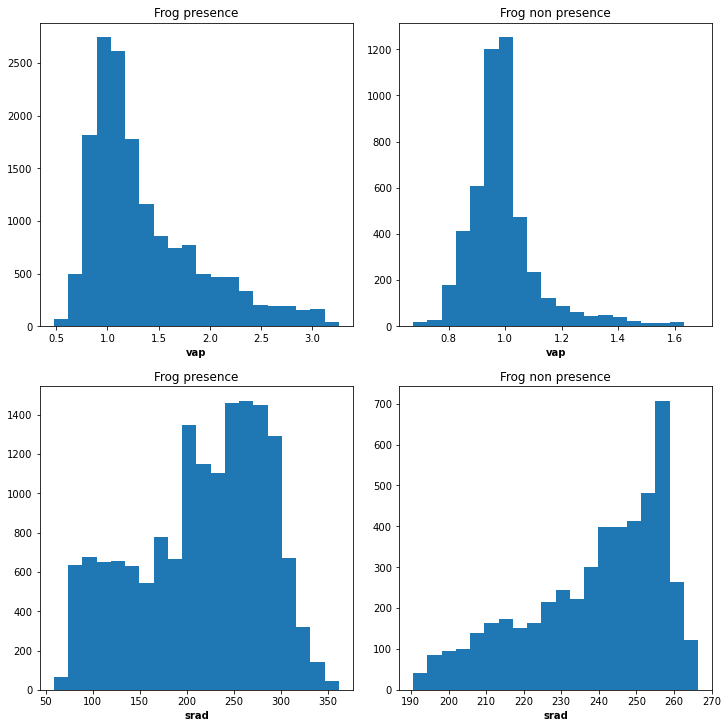

In [24]:
plot_columns = ['vap', 'srad']
print(len(plot_columns))

total_cols = 2
total_rows = len(plot_columns)
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(5*total_cols, 5*total_rows), constrained_layout=True)

for ax,var in zip(axs,plot_columns):
    ax[0].hist(x=df_frog_merged.loc[df_frog_merged[var].notna(),var],bins = 20)
    ax[0].set_title("Frog presence")
    ax[0].set_xlabel(var, fontweight ='bold')
    
    ax[1].hist(x=df_nonfrog_merged.loc[df_nonfrog_merged[var].notna(),var],bins = 20)
    ax[1].set_title("Frog non presence")
    ax[1].set_xlabel(var, fontweight ='bold')

## 5.Appending frog presence and non frog presence data

In [25]:
df_append = pd.concat([df_frog_merged,df_nonfrog_merged])
print("shape of df_append_g : ",df_append.shape)
df_append.tail()

shape of df_append_g :  (20770, 8)


,lat,lon,time,srad,count,std_deviation,vap,occurrenceStatusBool
4995,-21.0,145.1,NaN,246.820007,150,48.624858,1.399467,0
4996,-21.0,146.5,NaN,242.550003,100,48.983892,1.598100,0
4997,-21.0,146.6,NaN,242.266663,150,48.864100,1.598667,0
4998,-21.0,147.2,NaN,240.149994,100,49.356541,1.627900,0
4999,-21.0,147.7,NaN,238.729996,100,49.929820,1.649700,0


In [26]:
#selecting required columns for modeling
df_append.drop(["lat","lon","time","std_deviation","count"], inplace=True, axis=1)
df_append.tail()

,srad,vap,occurrenceStatusBool
4995,246.820007,1.399467,0
4996,242.550003,1.598100,0
4997,242.266663,1.598667,0
4998,240.149994,1.627900,0
4999,238.729996,1.649700,0


## 6.Data preprocessing for model building

### 6.1 Drop the duplicate entries

In [27]:
#dropping the duplicate entries
df_append = df_append.drop_duplicates()
df_append["occurrenceStatusBool"].value_counts()

1    15616
0     4882
Name: occurrenceStatusBool, dtype: int64

In [28]:
model_data = df_append.copy()

In [29]:
model_data.describe()

,srad,vap,occurrenceStatusBool
count,20496.000000,20496.000000,20498.000000
mean,221.339478,1.276724,0.761830
std,61.081444,0.502996,0.425974
min,58.666668,0.477778,0.000000
25%,193.153336,0.950000,1.000000
50%,235.860001,1.085000,1.000000
75%,261.090820,1.447117,1.000000
max,361.666656,3.260000,1.000000


### 6.2 Missing Value treatment

In [30]:
# calculating missing values in each columns 
for col in model_data.columns:
    miss_value_number = model_data[col].isna().sum()
    mis = ((model_data[col].isna().sum())/model_data[col].shape[0])*100
    print("missing valuein {} : is {} ---> {}%".format(col,miss_value_number,mis))

missing valuein srad : is 2 ---> 0.009757049468240804%
missing valuein vap : is 2 ---> 0.009757049468240804%
missing valuein occurrenceStatusBool : is 0 ---> 0.0%


In [31]:
#Handling missing values 
def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

model_data=model_data.apply(lambda x: Missing_imputation(x))

### 6.3 Outlier treatment

In [32]:
#Handling Outliers
def outlier_capping(x):
    x = x.clip(upper = x.quantile(0.99))
    x = x.clip(lower = x.quantile(0.01))
    return x

model_data.iloc[:,0:-1]=model_data.iloc[:,0:-1].apply(lambda x: outlier_capping(x))

### 6.4 Heatmap of climatic variables

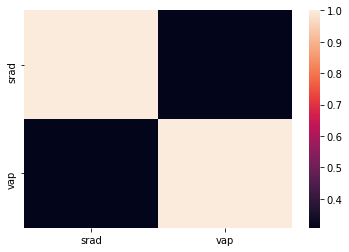

In [33]:
sns.heatmap(model_data.iloc[:,0:-1].corr())
plt.show()

In [34]:
x = model_data.iloc[:,0:-1]
y = model_data["occurrenceStatusBool"].values

### 6.5 Minmax scaling

In [35]:
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_x_scaled = pd.DataFrame(x_scaled)
df_x_scaled.columns =  model_data.iloc[:,0:-1].columns
final_data=df_x_scaled.assign(occurrenceStatusBool = y)

## 7.Binary Model building

### 7.1 Create train test dataset

In [36]:
#train test data splitting in 70:30 
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.30, random_state=42)

### 7.2 Train the algorithm

In [37]:
#training the logistic regression model
lr = LogisticRegression(max_iter=1000)
model=lr.fit(X_train,y_train)

## 8. Model Result & Analysis

### 8.1.Classification report on test data


In [38]:
y_pred=model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.51      0.29      0.37      1458
           1       0.81      0.91      0.86      4692

    accuracy                           0.77      6150
   macro avg       0.66      0.60      0.61      6150
weighted avg       0.74      0.77      0.74      6150



### 8.2.Confusion matrix on test data

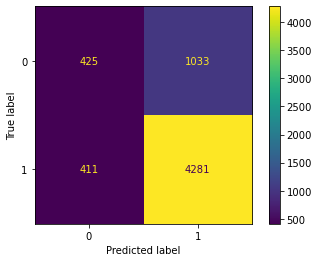

In [39]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

## 8.3 Saving model prediction into csv file

In [40]:
#prediction = pd.DataFrame(y_pred, columns=["prediction"])
  
# save the dataframe as a csv file
#prediction.to_csv("result.csv", index=False)

# Making a submission on the Out-of-Sample Validation
#### Yet to be drafted

In [ ]:
## An out-of-sample validation dataset has been provided for predicting the frog presence status on the specified region.
## Contestants should update the file with the frog presence status & upload on the EY platform for evaluation.